In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ML/DL Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# DL Model Components (Defined in Step 4, but imported here)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [23]:
# --- Project Constants ---
FAULT_START_TIME = 5.0 # Faults are induced at 5.0 seconds
N_STEPS = 200          # Length of one time-series sample (200 time steps)
N_FEATURES = 13        # Total measurement columns
N_CLASSES = 8          # F0 to F7

FILE_LABELS = {
    'F0L': 0, 'F0M': 0, 'F1L': 1, 'F1M': 1, 'F2L': 2, 'F2M': 2, 'F3L': 3, 'F3M': 3,
    'F4L': 4, 'F4M': 4, 'F5L': 5, 'F5M': 5, 'F6L': 6, 'F6M': 6, 'F7L': 7, 'F7M': 7,
}
FEATURE_COLUMNS = ['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'va', 'vb', 'vc', 'Iabc', 'If', 'Vabc', 'Vf']

In [24]:
master_df = []
loaded_files_count = 0

for file_code, fault_label in FILE_LABELS.items():
    file_name = f"drive/MyDrive/CSV_Files/{file_code}.csv"
    try:
        df = pd.read_csv(file_name)

        # Segmentation Logic
        if fault_label == 0:
            segment = df.copy() # Use all data for Healthy state
        else:
            # Use only data points AFTER the fault is introduced
            segment = df[df['Time'] >= FAULT_START_TIME].copy()

        # Add the target label column
        segment['Fault_Class'] = fault_label
        master_df.append(segment)
        loaded_files_count += 1

    except FileNotFoundError:
        print(f"File not found: {file_name}. Skipping...")
        pass

if master_df:
    master_df = pd.concat(master_df, ignore_index=True)
    print(f"✅ Data Loaded and Aggregated from {loaded_files_count} files.")
    print(f"Total Raw Data Points: {len(master_df)}")
else:
    print("❌ ERROR: No data files were successfully loaded.")

✅ Data Loaded and Aggregated from 16 files.
Total Raw Data Points: 1463369


In [26]:
def create_time_windows(df, n_steps, feature_cols, target_col):
    """Converts continuous data into 3D array (Samples, TimeSteps, Features)."""
    X, y = [], []
    i = 0
    # Non-overlapping window creation
    while i + n_steps <= len(df):
        x_window = df.iloc[i:i + n_steps][feature_cols].values
        # The label for the entire window is the mode of the labels within it
        y_window = df.iloc[i:i + n_steps][target_col].mode().iloc[0]

        X.append(x_window)
        y.append(y_window)
        i += n_steps
    return np.array(X), np.array(y)

In [27]:
# 1. Create Windows
X_raw, y_labels = create_time_windows(master_df, N_STEPS, FEATURE_COLUMNS, 'Fault_Class')

# 2. Train-Test Split (80% Train / 20% Test)
X_train_raw, X_test_raw, y_train_labels, y_test_labels = train_test_split(
    X_raw,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels # Ensures proportional representation of all 8 classes
)

# 3. Normalization using StandardScaler
scaler = StandardScaler()
# Reshape 3D training data to 2D for fitting the scaler: (Samples x (Steps*Features))
X_train_2d = X_train_raw.reshape(-1, N_STEPS * N_FEATURES)
scaler.fit(X_train_2d)

# Transform the data and reshape back to 3D for the CNN
X_train = scaler.transform(X_train_2d).reshape(X_train_raw.shape)
X_test = scaler.transform(X_test_raw.reshape(-1, N_STEPS * N_FEATURES)).reshape(X_test_raw.shape)

# 4. Final Label Encoding (One-Hot)
y_train = to_categorical(y_train_labels, num_classes=N_CLASSES)
y_test = to_categorical(y_test_labels, num_classes=N_CLASSES)

print("✅ FINAL DATA ARRAYS CREATED AND READY FOR MODEL.")
print(f"X_train shape: {X_train.shape} (Samples, TimeSteps, Features)")
print(f"y_train shape: {y_train.shape} (Samples, One-Hot Classes)")

✅ FINAL DATA ARRAYS CREATED AND READY FOR MODEL.
X_train shape: (5852, 200, 13) (Samples, TimeSteps, Features)
y_train shape: (5852, 8) (Samples, One-Hot Classes)


/tmp/ipython-input-3012717785.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_labels, order=y_labels_unique, palette='viridis')


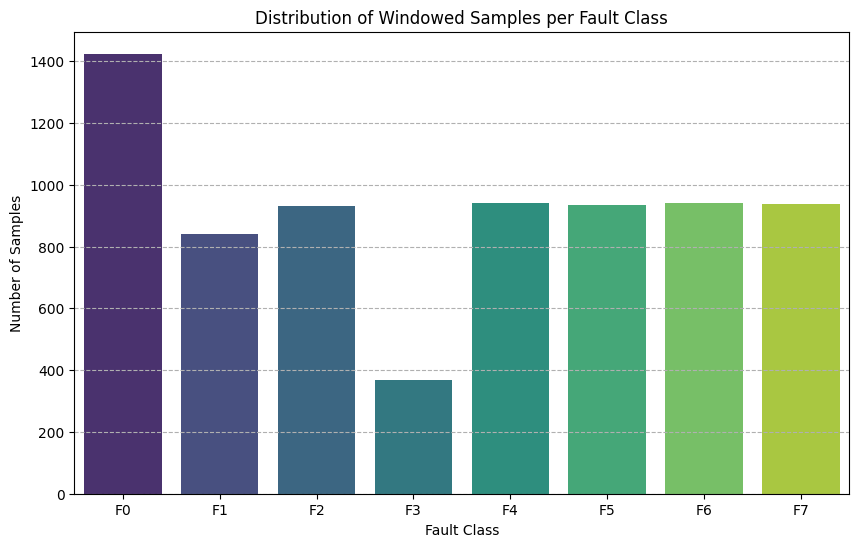

In [28]:
plt.figure(figsize=(10, 6))
# Count the final samples in the windowed data
y_labels_unique = sorted(np.unique(y_labels))
sns.countplot(x=y_labels, order=y_labels_unique, palette='viridis')
plt.title('Distribution of Windowed Samples per Fault Class')
plt.xlabel('Fault Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=y_labels_unique, labels=[f'F{i}' for i in y_labels_unique])
plt.grid(axis='y', linestyle='--')
plt.show() # Use plt.show() in Colab for immediate display

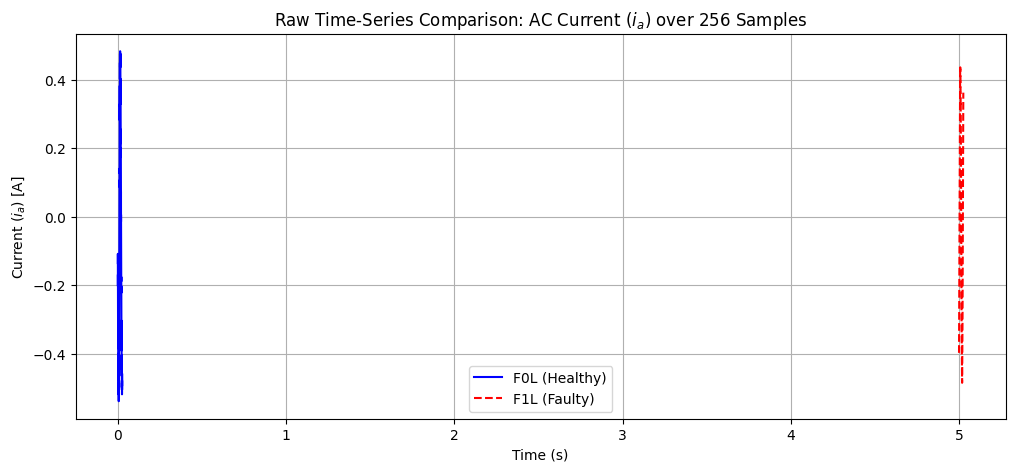

In [30]:
# Re-load F0L and F1L for visualization if not already in memory
F0L_df = pd.read_csv("drive/MyDrive/CSV_Files/F0L.csv")
F1L_df = pd.read_csv("drive/MyDrive/CSV_Files/F1L.csv")

F1L_fault_segment = F1L_df[F1L_df['Time'] >= FAULT_START_TIME]
N_POINTS_VIZ = 256

plt.figure(figsize=(12, 5))
plt.plot(F0L_df['Time'].iloc[:N_POINTS_VIZ], F0L_df['ia'].iloc[:N_POINTS_VIZ], label='F0L (Healthy)', color='blue')
plt.plot(F1L_fault_segment['Time'].iloc[:N_POINTS_VIZ], F1L_fault_segment['ia'].iloc[:N_POINTS_VIZ], label='F1L (Faulty)', color='red', linestyle='--')
plt.title(f'Raw Time-Series Comparison: AC Current ($i_a$) over {N_POINTS_VIZ} Samples')
plt.xlabel('Time (s)')
plt.ylabel('Current ($i_a$) [A]')
plt.grid(True)
plt.legend()
plt.show()

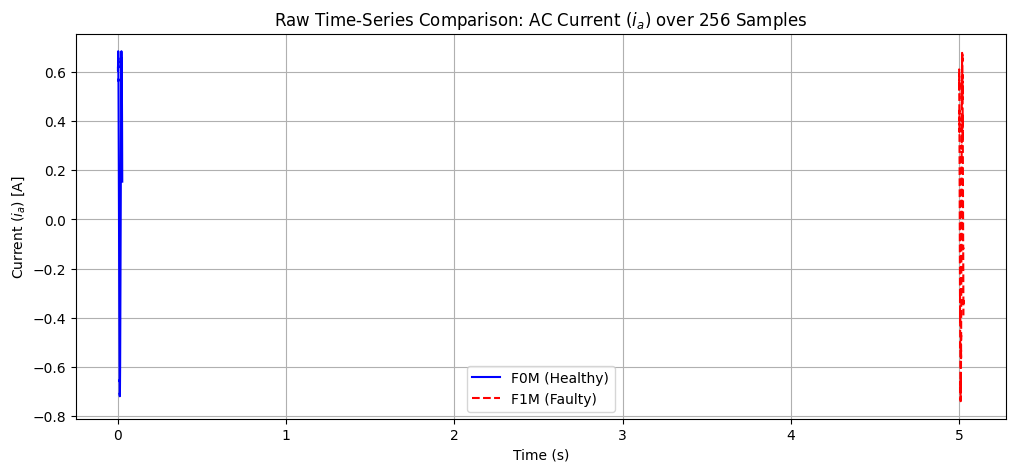

In [31]:
# Re-load F0L and F1L for visualization if not already in memory
F0M_df = pd.read_csv("drive/MyDrive/CSV_Files/F0M.csv")
F1M_df = pd.read_csv("drive/MyDrive/CSV_Files/F1M.csv")

F1M_fault_segment = F1M_df[F1M_df['Time'] >= FAULT_START_TIME]
N_POINTS_VIZ = 256

plt.figure(figsize=(12, 5))
plt.plot(F0M_df['Time'].iloc[:N_POINTS_VIZ], F0M_df['ia'].iloc[:N_POINTS_VIZ], label='F0M (Healthy)', color='blue')
plt.plot(F1M_fault_segment['Time'].iloc[:N_POINTS_VIZ], F1M_fault_segment['ia'].iloc[:N_POINTS_VIZ], label='F1M (Faulty)', color='red', linestyle='--')
plt.title(f'Raw Time-Series Comparison: AC Current ($i_a$) over {N_POINTS_VIZ} Samples')
plt.xlabel('Time (s)')
plt.ylabel('Current ($i_a$) [A]')
plt.grid(True)
plt.legend()
plt.show()